Modelo One-Asset (Um entendimento amador, ainda!!!!!)

Função de transferencia é igual a dividendos menos taxas.


In [16]:
def transfers(pi_e, Div, Tax, e_grid, div_rule, tax_rule):    
    div = Div / np.sum(pi_e * div_rule) * div_rule
    tax = Tax / np.sum(pi_e * tax_rule) * tax_rule
    T = div - tax
    return T

In [17]:
household = hank.household.attach_hetinput(transfers)

No estado estacionário calibramos o fator de desconto $\beta$ e desutilidade do trabalho $\varphi$ para atingir um alvo para a taxa de juros e mão-de-obra efetiva $L=1$.


Temos que resolver um problema bidimensional de procura de raízes, para isso utilizamos o método de Broyden implementado no módulo utils.py. O método consiste em uma função $f:\mathbb{R}^n \to \mathbb{R}^n$ com uma estimativa inicial para as raizes, $x_0\in \mathbb{R}^n$,  reiniciando sempre que $f$ devolva um ValueError.


In [18]:
def hank_ss(beta_guess=0.986, vphi_guess=0.8, r=0.005, eis=0.5, frisch=0.5, mu=1.2, B_Y=5.6, rho_s=0.966, sigma_s=0.5,
            kappa=0.1, phi=1.5, nS=7, amax=150, nA=500, tax_rule=None, div_rule=None):
    """Solve steady state of full GE model. Calibrate (beta, vphi) to hit target for interest rate and Y."""

    # set up grid
    a_grid = utils.agrid(amax=amax, n=nA)
    e_grid, pi_e, Pi = utils.markov_rouwenhorst(rho=rho_s, sigma=sigma_s, N=nS)
    
    # default incidence rules are proportional to skill
    if tax_rule is None:
        tax_rule = e_grid  # scale does not matter, will be normalized anyway
    if div_rule is None:
        div_rule = e_grid
    assert len(tax_rule) == len(div_rule) == len(e_grid), 'Incidence rules are inconsistent with income grid.'

    # solve analytically what we can
    B = B_Y
    w = 1 / mu
    Div = (1 - w)
    Tax = r * B
    T = transfers(pi_e, Div, Tax, e_grid, div_rule, tax_rule)

    # initialize guess for policy function iteration
    fininc = (1 + r) * a_grid + T[:, np.newaxis] - a_grid[0]
    coh = (1 + r) * a_grid[np.newaxis, :] + w * e_grid[:, np.newaxis] + T[:, np.newaxis]
    Va = (1 + r) * (0.1 * coh) ** (-1 / eis)
 # residual function
    def res(x):
        beta_loc, vphi_loc = x
        # precompute constrained c and n which don't depend on Va
        c_const_loc, n_const_loc = hank.solve_cn(w * e_grid[:, np.newaxis], fininc, eis, frisch, vphi_loc, Va)
        if beta_loc > 0.999 / (1 + r) or vphi_loc < 0.001:
            raise ValueError('Clearly invalid inputs')
        out = household.ss(Va=Va, Pi=Pi, a_grid=a_grid, e_grid=e_grid, pi_e=pi_e, w=w, r=r, beta=beta_loc, eis=eis,
                           Div=Div, Tax=Tax, frisch=frisch, vphi=vphi_loc, c_const=c_const_loc, n_const=n_const_loc,
                           tax_rule=tax_rule, div_rule=div_rule, ssflag=True)
        return np.array([out['A'] - B, out['NS'] - 1])

    # solve for beta, vphi
    (beta, vphi), _ = utils.broyden_solver(res, np.array([beta_guess, vphi_guess]), noisy=False)

    # extra evaluation for reporting
    c_const, n_const = hank.solve_cn(w * e_grid[:, np.newaxis], fininc, eis, frisch, vphi, Va)
    ss = household.ss(Va=Va, Pi=Pi, a_grid=a_grid, e_grid=e_grid, pi_e=pi_e, w=w, r=r, beta=beta, eis=eis,
                      Div=Div, Tax=Tax, frisch=frisch, vphi=vphi, c_const=c_const, n_const=n_const,
                      tax_rule=tax_rule, div_rule=div_rule, ssflag=True)
    
    # check Walras's law
    walras = 1 - ss['C']
    assert np.abs(walras) < 1E-8
    
    # add aggregate variables
    ss.update({'B': B, 'phi': phi, 'kappa': kappa, 'Y': 1, 'rstar': r, 'Z': 1, 'mu': mu, 'L': 1, 'pi': 0,
               'walras': walras, 'ssflag': False})
    return ss

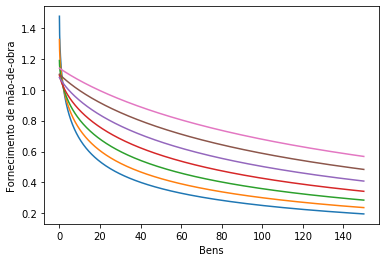

In [19]:
ss = hank_ss()
plt.plot(ss['a_grid'], ss['n'].T)
plt.xlabel('Bens'), plt.ylabel('Fornecimento de mão-de-obra')
plt.show()